In [1]:
import pandas as pd

In [57]:
df = pd.read_parquet('data\Austria_Inflation_(CPI).parquet')
df = df.set_index('Year')
df.index = pd.to_datetime(df.index, format='%Y').strftime('%Y')
df.index = pd.to_datetime(df.index, format='%Y')
df = df.drop('Indicator', axis = 1)
df = df.dropna()
df.head()

Value
Year                
1960-01-01  1.945749
1961-01-01  3.542240
1962-01-01  4.381799
1963-01-01  2.708767
1964-01-01  3.868564

In [58]:
df.index

DatetimeIndex(['1960-01-01', '1961-01-01', '1962-01-01', '1963-01-01',
               '1964-01-01', '1965-01-01', '1966-01-01', '1967-01-01',
               '1968-01-01', '1969-01-01', '1970-01-01', '1971-01-01',
               '1972-01-01', '1973-01-01', '1974-01-01', '1975-01-01',
               '1976-01-01', '1977-01-01', '1978-01-01', '1979-01-01',
               '1980-01-01', '1981-01-01', '1982-01-01', '1983-01-01',
               '1984-01-01', '1985-01-01', '1986-01-01', '1987-01-01',
               '1988-01-01', '1989-01-01', '1990-01-01', '1991-01-01',
               '1992-01-01', '1993-01-01', '1994-01-01', '1995-01-01',
               '1996-01-01', '1997-01-01', '1998-01-01', '1999-01-01',
               '2000-01-01', '2001-01-01', '2002-01-01', '2003-01-01',
               '2004-01-01', '2005-01-01', '2006-01-01', '2007-01-01',
               '2008-01-01', '2009-01-01', '2010-01-01', '2011-01-01',
               '2012-01-01', '2013-01-01', '2014-01-01', '2015-01-01',
      

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

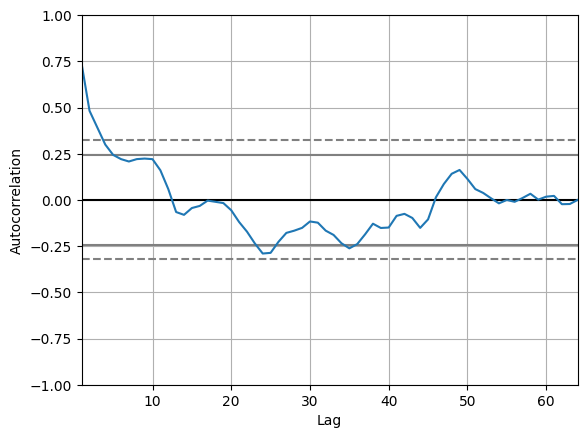

In [59]:

from pandas.plotting import lag_plot , autocorrelation_plot

autocorrelation_plot(df)

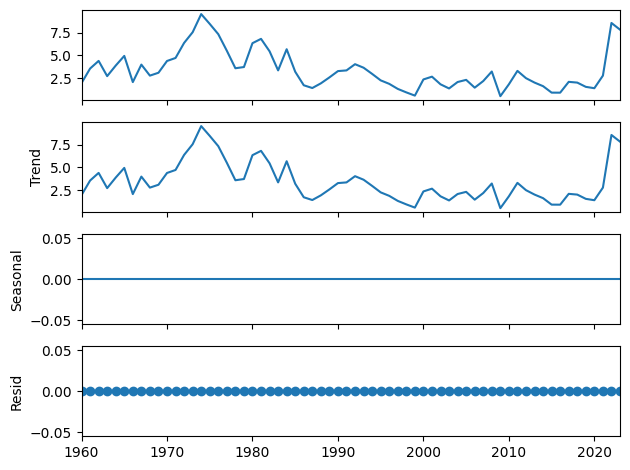

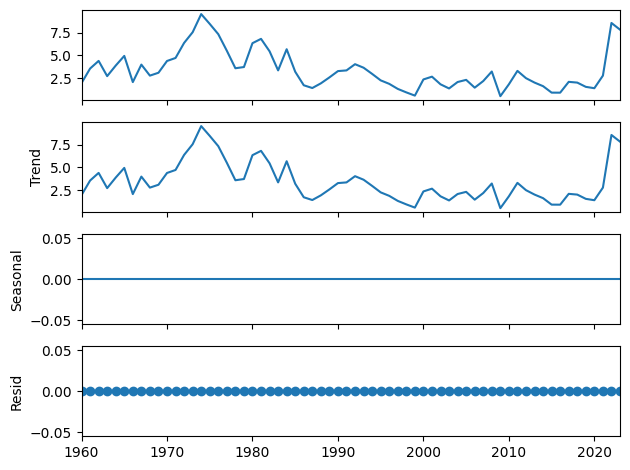

In [60]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df, model='additive' , period=1)
result.plot()


In [72]:
import os
import json
import pandas as pd
import numpy as np
import xgboost as xgb
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense , Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

def train_xgboost(train_x, train_y, test_x, test_y, top_n_features=10):
    # Define the parameter grid for GridSearchCV
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5]
    }

    # Initialize the XGBoost regressor
    model = xgb.XGBRegressor(objective='reg:squarederror')

    # Perform GridSearchCV to find the best hyperparameters
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error')
    grid_search.fit(train_x, train_y)

    # Get the best model from GridSearchCV
    best_model = grid_search.best_estimator_

    # Perform Recursive Feature Elimination (RFE)
    selector = RFE(estimator=best_model, n_features_to_select=top_n_features)
    selector = selector.fit(train_x, train_y)

    # Select the top N important features based on RFE
    selected_train_x = selector.transform(train_x)
    selected_test_x = selector.transform(test_x)

    # Train the model again with the selected features
    best_model.fit(selected_train_x, train_y)

    # Make predictions on the test set using the selected features
    predictions = best_model.predict(selected_test_x)

    # Calculate the RMSE on the test set
    return np.sqrt(mean_squared_error(test_y, predictions))


def train_arima(train_y, test_y):
    best_rmse = float('inf')
    best_order = None
    
    for p in range(4):
        for d in range(4):
            for q in range(4):
                try:
                    model = ARIMA(train_y, order=(p, d, q))
                    model_fit = model.fit()
                    predictions = model_fit.forecast(steps=len(test_y))
                    rmse = np.sqrt(mean_squared_error(test_y, predictions))
                    if rmse < best_rmse:
                        best_rmse = rmse
                        best_order = (p, d, q)
                except:
                    continue
    return best_rmse


def train_prophet(train_df, test_y):
    train_df['ds'] = pd.to_datetime(train_df['ds'])  # Ensure datetime format
    
    param_grid = {
        'changepoint_prior_scale': [0.01, 0.1, 0.5],
        'seasonality_mode': ['additive', 'multiplicative'],
    }

    best_rmse = float('inf')
    best_params = None

    for changepoint_prior in param_grid['changepoint_prior_scale']:
        for seasonality_mode in param_grid['seasonality_mode']:
            model = Prophet(
                yearly_seasonality=True,
                weekly_seasonality=False,
                daily_seasonality=False,
                changepoint_prior_scale=changepoint_prior,
                seasonality_mode=seasonality_mode
            )
            model.fit(train_df)

            future = model.make_future_dataframe(periods=len(test_y), freq='Y')
            forecast = model.predict(future)
            predictions = forecast['yhat'].iloc[-len(test_y):].values
            rmse = np.sqrt(mean_squared_error(test_y, predictions))

            if rmse < best_rmse:
                best_rmse = rmse
                best_params = (changepoint_prior, seasonality_mode)

    # Train best model
    best_model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        changepoint_prior_scale=best_params[0],
        seasonality_mode=best_params[1]
    )
    best_model.fit(train_df)
    future = best_model.make_future_dataframe(periods=len(test_y), freq='Y')
    forecast = best_model.predict(future)
    predictions = forecast['yhat'].iloc[-len(test_y):].values

    return np.sqrt(mean_squared_error(test_y, predictions))

def train_holt_winters(train, test_y):
    param_grid = {
        'trend': [None, 'add', 'mul'],
        'seasonal': [None, 'add', 'mul'],
        'seasonal_periods': [None, 12]
    }

    best_rmse = float('inf')
    best_params = None

    for trend in param_grid['trend']:
        for seasonal in param_grid['seasonal']:
            for seasonal_periods in param_grid['seasonal_periods']:
                try:
                    model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods)
                    fitted_model = model.fit()
                    predictions = fitted_model.forecast(len(test_y))
                    rmse = np.sqrt(mean_squared_error(test_y, predictions))

                    if rmse < best_rmse:
                        best_rmse = rmse
                        best_params = (trend, seasonal, seasonal_periods)
                except:
                    continue

    best_model = ExponentialSmoothing(train, trend=best_params[0], seasonal=best_params[1], seasonal_periods=best_params[2])
    best_fitted_model = best_model.fit()
    predictions = best_fitted_model.forecast(len(test_y))

    return np.sqrt(mean_squared_error(test_y, predictions))



def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length])
    return np.array(sequences), np.array(labels)

def train_lstm(train, test_y, seq_length=5, epochs=50, batch_size=16):
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train.values.reshape(-1, 1))
    test_scaled = scaler.transform(test_y.values.reshape(-1, 1))
    
    X_train, y_train = create_sequences(train_scaled, seq_length)
    X_test, y_test = create_sequences(test_scaled, seq_length)
    
    model = Sequential([
        LSTM(100, activation='relu', return_sequences=True, input_shape=(seq_length, 1)),
        Dropout(0.3),
        LSTM(100, activation='relu'),
        Dropout(0.3),
        Dense(1)
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0, callbacks=[early_stop])
    
    predictions = model.predict(X_test).flatten()
    predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
    
    rmse = np.sqrt(mean_squared_error(test_y[seq_length:], predictions))

    
    return rmse


with open("countries.json", "r") as f:
    country_names = json.load(f)

with open("indicators.json", "r") as f:
    indicators = json.load(f)

data_folder = "data"
model_errors_rmse = {}
log_data = []

for country, country_code in country_names.items():
    for indicator, indicator_code in indicators.items():
        filename = f"{country.replace(' ', '_')}_{indicator.replace(' ', '_')}.parquet"
        filepath = os.path.join(data_folder, filename)
        
        if os.path.exists(filepath):
            df = pd.read_parquet(filepath)
            if 'Year' in df.columns and 'Value' in df.columns:
                df = df.set_index('Year').sort_index()
                df.index = pd.to_datetime(df.index, format='%Y')
                df = df.dropna()
                df = df.drop('Indicator', axis = 1)
                df_original = df.copy()
                
                for lag in range(1, 6):  
                    df[f'lag_{lag}'] = df['Value'].shift(lag)
                
                df['expanding_mean'] = df['Value'].expanding().mean()
                df['expanding_std'] = df['Value'].expanding().std()
                df['expanding_max'] = df['Value'].expanding().max()
                df['expanding_min'] = df['Value'].expanding().min()
                
                window_size = 3  
                df['rolling_mean'] = df['Value'].rolling(window=window_size, min_periods=1).mean()
                df['rolling_std'] = df['Value'].rolling(window=window_size, min_periods=1).std()
                df['rolling_max'] = df['Value'].rolling(window=window_size, min_periods=1).max()
                df['rolling_min'] = df['Value'].rolling(window=window_size, min_periods=1).min()
                
                
                #df = df.dropna()
                train_size = int(len(df) * 0.8)
                
                train_xgb, test_xgb = df.iloc[:train_size], df.iloc[train_size:]
                feature_columns = ['rolling_mean', 'rolling_std', 'rolling_max', 'rolling_min', 
                                   'expanding_mean', 'expanding_std', 'expanding_max', 'expanding_min',
                                   'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5']
                train_x, train_y = train_xgb[feature_columns], train_xgb['Value']
                test_x, test_y = test_xgb[feature_columns], test_xgb['Value']
                
                model_errors_rmse[(country, indicator)] = {}
                model_errors_rmse[(country, indicator)]['XGBoost'] = train_xgboost(train_x, train_y, test_x, test_y)
                model_errors_rmse[(country, indicator)]['ARIMA'] = train_arima(df_original.iloc[:train_size]['Value'], df_original.iloc[train_size:]['Value'])
                model_errors_rmse[(country, indicator)]['Holt-Winters'] = train_holt_winters(df_original.iloc[:train_size]['Value'], df_original.iloc[train_size:]['Value'])
                model_errors_rmse[(country, indicator)]['LSTM'] = train_lstm(df_original.iloc[:train_size]['Value'], df_original.iloc[train_size:]['Value'])


                prophet_train_df = df_original.iloc[:train_size].reset_index().rename(columns={'Year': 'ds', 'Value': 'y'})
                prophet_test_df = df_original.iloc[train_size:].reset_index().rename(columns={'Year': 'ds', 'Value': 'y'})
                prophet_train_df['ds'] = pd.to_datetime(prophet_train_df['ds'])
                prophet_test_df['ds'] = pd.to_datetime(prophet_test_df['ds'])
                model_errors_rmse[(country, indicator)]['Prophet'] = train_prophet(prophet_train_df, prophet_test_df['y'])
                
                sorted_models = sorted(model_errors_rmse[(country, indicator)].items(), key=lambda x: x[1])
                for rank, (model_name, rmse) in enumerate(sorted_models, start=1):
                    log_data.append([country, indicator, model_name, rmse, rank])

log_df = pd.DataFrame(log_data, columns=['Country', 'Indicator', 'Model', 'RMSE', 'Rank'])
log_df.to_csv("model_error_log.csv", index=False)


c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\admin\Desktop\diplomovk

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


17:37:10 - cmdstanpy - INFO - Chain [1] start processing
17:37:10 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:37:10 - cmdstanpy - INFO - Chain [1] start processing
17:37:10 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:37:10 - cmdstanpy - INFO - Chain [1] start processing
17:37:11 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


17:37:27 - cmdstanpy - INFO - Chain [1] start processing
17:37:27 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:37:27 - cmdstanpy - INFO - Chain [1] start processing
17:37:28 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:37:28 - cmdstanpy - INFO - Chain [1] start processing
17:37:28 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


17:37:47 - cmdstanpy - INFO - Chain [1] start processing
17:37:47 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:37:47 - cmdstanpy - INFO - Chain [1] start processing
17:37:47 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:37:47 - cmdstanpy - INFO - Chain [1] start processing
17:37:47 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


17:38:05 - cmdstanpy - INFO - Chain [1] start processing
17:38:05 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:38:05 - cmdstanpy - INFO - Chain [1] start processing
17:38:05 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:38:06 - cmdstanpy - INFO - Chain [1] start processing
17:38:06 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


17:38:25 - cmdstanpy - INFO - Chain [1] start processing
17:38:25 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:38:25 - cmdstanpy - INFO - Chain [1] start processing
17:38:26 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:38:26 - cmdstanpy - INFO - Chain [1] start processing
17:38:26 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


17:38:48 - cmdstanpy - INFO - Chain [1] start processing
17:38:48 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:38:48 - cmdstanpy - INFO - Chain [1] start processing
17:38:48 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:38:48 - cmdstanpy - INFO - Chain [1] start processing
17:38:48 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


17:39:11 - cmdstanpy - INFO - Chain [1] start processing
17:39:11 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:39:11 - cmdstanpy - INFO - Chain [1] start processing
17:39:11 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:39:11 - cmdstanpy - INFO - Chain [1] start processing
17:39:12 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


17:39:35 - cmdstanpy - INFO - Chain [1] start processing
17:39:35 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:39:35 - cmdstanpy - INFO - Chain [1] start processing
17:39:35 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:39:36 - cmdstanpy - INFO - Chain [1] start processing
17:39:36 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


17:39:58 - cmdstanpy - INFO - Chain [1] start processing
17:39:58 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:39:58 - cmdstanpy - INFO - Chain [1] start processing
17:39:58 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:39:58 - cmdstanpy - INFO - Chain [1] start processing
17:39:59 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


17:40:21 - cmdstanpy - INFO - Chain [1] start processing
17:40:21 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:40:21 - cmdstanpy - INFO - Chain [1] start processing
17:40:21 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:40:21 - cmdstanpy - INFO - Chain [1] start processing
17:40:21 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


17:40:41 - cmdstanpy - INFO - Chain [1] start processing
17:40:41 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:40:41 - cmdstanpy - INFO - Chain [1] start processing
17:40:41 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:40:41 - cmdstanpy - INFO - Chain [1] start processing
17:40:41 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


17:41:02 - cmdstanpy - INFO - Chain [1] start processing
17:41:02 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:41:02 - cmdstanpy - INFO - Chain [1] start processing
17:41:02 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:41:02 - cmdstanpy - INFO - Chain [1] start processing
17:41:02 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


17:41:22 - cmdstanpy - INFO - Chain [1] start processing
17:41:22 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:41:22 - cmdstanpy - INFO - Chain [1] start processing
17:41:23 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:41:23 - cmdstanpy - INFO - Chain [1] start processing
17:41:23 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


17:41:45 - cmdstanpy - INFO - Chain [1] start processing
17:41:45 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:41:45 - cmdstanpy - INFO - Chain [1] start processing
17:41:45 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:41:45 - cmdstanpy - INFO - Chain [1] start processing
17:41:45 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


17:42:07 - cmdstanpy - INFO - Chain [1] start processing
17:42:07 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:42:07 - cmdstanpy - INFO - Chain [1] start processing
17:42:07 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:42:07 - cmdstanpy - INFO - Chain [1] start processing
17:42:07 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


17:42:25 - cmdstanpy - INFO - Chain [1] start processing
17:42:25 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:42:25 - cmdstanpy - INFO - Chain [1] start processing
17:42:25 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:42:25 - cmdstanpy - INFO - Chain [1] start processing
17:42:25 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


17:42:44 - cmdstanpy - INFO - Chain [1] start processing
17:42:44 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:42:45 - cmdstanpy - INFO - Chain [1] start processing
17:42:45 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:42:45 - cmdstanpy - INFO - Chain [1] start processing
17:42:45 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


17:43:04 - cmdstanpy - INFO - Chain [1] start processing
17:43:04 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:43:04 - cmdstanpy - INFO - Chain [1] start processing
17:43:04 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:43:04 - cmdstanpy - INFO - Chain [1] start processing
17:43:04 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


17:43:25 - cmdstanpy - INFO - Chain [1] start processing
17:43:25 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:43:25 - cmdstanpy - INFO - Chain [1] start processing
17:43:25 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:43:25 - cmdstanpy - INFO - Chain [1] start processing
17:43:25 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


17:43:47 - cmdstanpy - INFO - Chain [1] start processing
17:43:47 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:43:47 - cmdstanpy - INFO - Chain [1] start processing
17:43:47 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:43:47 - cmdstanpy - INFO - Chain [1] start processing
17:43:48 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


17:44:07 - cmdstanpy - INFO - Chain [1] start processing
17:44:08 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:44:08 - cmdstanpy - INFO - Chain [1] start processing
17:44:08 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:44:08 - cmdstanpy - INFO - Chain [1] start processing
17:44:08 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


17:44:29 - cmdstanpy - INFO - Chain [1] start processing
17:44:29 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:44:29 - cmdstanpy - INFO - Chain [1] start processing
17:44:29 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:44:29 - cmdstanpy - INFO - Chain [1] start processing
17:44:29 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


17:44:45 - cmdstanpy - INFO - Chain [1] start processing
17:44:45 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:44:45 - cmdstanpy - INFO - Chain [1] start processing
17:44:45 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:44:45 - cmdstanpy - INFO - Chain [1] start processing
17:44:45 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


17:45:05 - cmdstanpy - INFO - Chain [1] start processing
17:45:05 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:45:05 - cmdstanpy - INFO - Chain [1] start processing
17:45:05 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:45:05 - cmdstanpy - INFO - Chain [1] start processing
17:45:05 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


17:45:25 - cmdstanpy - INFO - Chain [1] start processing
17:45:25 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:45:25 - cmdstanpy - INFO - Chain [1] start processing
17:45:25 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:45:25 - cmdstanpy - INFO - Chain [1] start processing
17:45:25 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


17:45:43 - cmdstanpy - INFO - Chain [1] start processing
17:45:43 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:45:43 - cmdstanpy - INFO - Chain [1] start processing
17:45:43 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:45:44 - cmdstanpy - INFO - Chain [1] start processing
17:45:44 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


17:46:04 - cmdstanpy - INFO - Chain [1] start processing
17:46:04 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:46:04 - cmdstanpy - INFO - Chain [1] start processing
17:46:04 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:46:04 - cmdstanpy - INFO - Chain [1] start processing
17:46:04 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


17:46:27 - cmdstanpy - INFO - Chain [1] start processing
17:46:27 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:46:27 - cmdstanpy - INFO - Chain [1] start processing
17:46:27 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:46:27 - cmdstanpy - INFO - Chain [1] start processing
17:46:27 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


17:46:50 - cmdstanpy - INFO - Chain [1] start processing
17:46:50 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:46:50 - cmdstanpy - INFO - Chain [1] start processing
17:46:50 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:46:50 - cmdstanpy - INFO - Chain [1] start processing
17:46:50 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


17:47:11 - cmdstanpy - INFO - Chain [1] start processing
17:47:11 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:47:11 - cmdstanpy - INFO - Chain [1] start processing
17:47:11 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:47:11 - cmdstanpy - INFO - Chain [1] start processing
17:47:11 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


17:47:33 - cmdstanpy - INFO - Chain [1] start processing
17:47:33 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:47:34 - cmdstanpy - INFO - Chain [1] start processing
17:47:34 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:47:34 - cmdstanpy - INFO - Chain [1] start processing
17:47:34 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


17:47:54 - cmdstanpy - INFO - Chain [1] start processing
17:47:54 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:47:55 - cmdstanpy - INFO - Chain [1] start processing
17:47:55 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:47:55 - cmdstanpy - INFO - Chain [1] start processing
17:47:55 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


17:48:18 - cmdstanpy - INFO - Chain [1] start processing
17:48:18 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:48:19 - cmdstanpy - INFO - Chain [1] start processing
17:48:19 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:48:19 - cmdstanpy - INFO - Chain [1] start processing
17:48:19 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


17:48:41 - cmdstanpy - INFO - Chain [1] start processing
17:48:41 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:48:41 - cmdstanpy - INFO - Chain [1] start processing
17:48:41 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:48:41 - cmdstanpy - INFO - Chain [1] start processing
17:48:41 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


17:49:04 - cmdstanpy - INFO - Chain [1] start processing
17:49:05 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:49:05 - cmdstanpy - INFO - Chain [1] start processing
17:49:05 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:49:05 - cmdstanpy - INFO - Chain [1] start processing
17:49:05 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


17:49:29 - cmdstanpy - INFO - Chain [1] start processing
17:49:29 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:49:29 - cmdstanpy - INFO - Chain [1] start processing
17:49:30 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:49:30 - cmdstanpy - INFO - Chain [1] start processing
17:49:30 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


17:49:51 - cmdstanpy - INFO - Chain [1] start processing
17:49:51 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:49:52 - cmdstanpy - INFO - Chain [1] start processing
17:49:52 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:49:52 - cmdstanpy - INFO - Chain [1] start processing
17:49:52 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


17:50:15 - cmdstanpy - INFO - Chain [1] start processing
17:50:15 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:50:15 - cmdstanpy - INFO - Chain [1] start processing
17:50:16 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:50:16 - cmdstanpy - INFO - Chain [1] start processing
17:50:16 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


17:50:39 - cmdstanpy - INFO - Chain [1] start processing
17:50:39 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:50:39 - cmdstanpy - INFO - Chain [1] start processing
17:50:39 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:50:39 - cmdstanpy - INFO - Chain [1] start processing
17:50:40 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


17:50:59 - cmdstanpy - INFO - Chain [1] start processing
17:50:59 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:50:59 - cmdstanpy - INFO - Chain [1] start processing
17:50:59 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:50:59 - cmdstanpy - INFO - Chain [1] start processing
17:51:00 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


17:51:23 - cmdstanpy - INFO - Chain [1] start processing
17:51:23 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:51:23 - cmdstanpy - INFO - Chain [1] start processing
17:51:23 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:51:23 - cmdstanpy - INFO - Chain [1] start processing
17:51:23 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


17:51:49 - cmdstanpy - INFO - Chain [1] start processing
17:51:49 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:51:49 - cmdstanpy - INFO - Chain [1] start processing
17:51:49 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:51:49 - cmdstanpy - INFO - Chain [1] start processing
17:51:50 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dat

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


17:52:16 - cmdstanpy - INFO - Chain [1] start processing
17:52:16 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:52:16 - cmdstanpy - INFO - Chain [1] start processing
17:52:16 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:52:16 - cmdstanpy - INFO - Chain [1] start processing
17:52:17 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


17:52:43 - cmdstanpy - INFO - Chain [1] start processing
17:52:43 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:52:43 - cmdstanpy - INFO - Chain [1] start processing
17:52:44 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:52:44 - cmdstanpy - INFO - Chain [1] start processing
17:52:44 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


17:53:10 - cmdstanpy - INFO - Chain [1] start processing
17:53:10 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:53:10 - cmdstanpy - INFO - Chain [1] start processing
17:53:10 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:53:11 - cmdstanpy - INFO - Chain [1] start processing
17:53:11 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


17:53:33 - cmdstanpy - INFO - Chain [1] start processing
17:53:33 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:53:33 - cmdstanpy - INFO - Chain [1] start processing
17:53:33 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:53:33 - cmdstanpy - INFO - Chain [1] start processing
17:53:33 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


17:53:58 - cmdstanpy - INFO - Chain [1] start processing
17:53:59 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:53:59 - cmdstanpy - INFO - Chain [1] start processing
17:53:59 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:53:59 - cmdstanpy - INFO - Chain [1] start processing
17:53:59 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


17:54:23 - cmdstanpy - INFO - Chain [1] start processing
17:54:23 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:54:23 - cmdstanpy - INFO - Chain [1] start processing
17:54:23 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:54:24 - cmdstanpy - INFO - Chain [1] start processing
17:54:24 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


17:54:49 - cmdstanpy - INFO - Chain [1] start processing
17:54:49 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:54:49 - cmdstanpy - INFO - Chain [1] start processing
17:54:49 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:54:49 - cmdstanpy - INFO - Chain [1] start processing
17:54:50 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


17:55:14 - cmdstanpy - INFO - Chain [1] start processing
17:55:14 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:55:14 - cmdstanpy - INFO - Chain [1] start processing
17:55:14 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:55:14 - cmdstanpy - INFO - Chain [1] start processing
17:55:15 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


17:55:35 - cmdstanpy - INFO - Chain [1] start processing
17:55:35 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:55:35 - cmdstanpy - INFO - Chain [1] start processing
17:55:35 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:55:36 - cmdstanpy - INFO - Chain [1] start processing
17:55:36 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


17:55:59 - cmdstanpy - INFO - Chain [1] start processing
17:55:59 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:55:59 - cmdstanpy - INFO - Chain [1] start processing
17:55:59 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:55:59 - cmdstanpy - INFO - Chain [1] start processing
17:55:59 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


17:56:20 - cmdstanpy - INFO - Chain [1] start processing
17:56:20 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:56:20 - cmdstanpy - INFO - Chain [1] start processing
17:56:20 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:56:20 - cmdstanpy - INFO - Chain [1] start processing
17:56:20 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


17:56:43 - cmdstanpy - INFO - Chain [1] start processing
17:56:44 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:56:44 - cmdstanpy - INFO - Chain [1] start processing
17:56:44 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:56:44 - cmdstanpy - INFO - Chain [1] start processing
17:56:44 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


17:57:06 - cmdstanpy - INFO - Chain [1] start processing
17:57:06 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:57:06 - cmdstanpy - INFO - Chain [1] start processing
17:57:06 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:57:06 - cmdstanpy - INFO - Chain [1] start processing
17:57:06 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


17:57:29 - cmdstanpy - INFO - Chain [1] start processing
17:57:29 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:57:29 - cmdstanpy - INFO - Chain [1] start processing
17:57:29 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
17:57:29 - cmdstanpy - INFO - Chain [1] start processing
17:57:29 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dat

In [60]:
df_original.shape

(54, 1)

In [61]:
log_df.loc[log_df['Indicator']=="Inflation (CPI)",:]

Country        Indicator    Model       RMSE  Rank
6    Czech Republic  Inflation (CPI)  XGBoost   2.716355     1
7    Czech Republic  Inflation (CPI)    ARIMA   3.068765     2
8    Czech Republic  Inflation (CPI)  Prophet   7.188270     3
27          Hungary  Inflation (CPI)  XGBoost   3.427655     1
28          Hungary  Inflation (CPI)    ARIMA   5.450300     2
29          Hungary  Inflation (CPI)  Prophet   5.689929     3
48           Poland  Inflation (CPI)  Prophet   4.493903     1
49           Poland  Inflation (CPI)    ARIMA   4.528208     2
50           Poland  Inflation (CPI)  XGBoost  12.869369     3
69         Slovakia  Inflation (CPI)    ARIMA   2.499848     1
70         Slovakia  Inflation (CPI)  XGBoost   5.323898     2
71         Slovakia  Inflation (CPI)  Prophet   8.942961     3
90          Germany  Inflation (CPI)  XGBoost   0.961240     1
91          Germany  Inflation (CPI)    ARIMA   1.584830     2
92          Germany  Inflation (CPI)  Prophet   1.954567     3
111         Austria  Inflation (CPI)  XGBoost   1.661173     1
112         Austria  Inflation (CPI)    ARIMA   1.892595     2
113         Austria  Inflation (CPI)  Prophet   2.403661     3
132          France  Inflation (CPI)  XGBoost   1.075605     1
133          France  Inflation (CPI)    ARIMA   1.428492     2
134          France  Inflation (CPI)  Prophet   1.542932     3
153           Italy  Inflation (CPI)  XGBoost   1.611912     1
154           Italy  Inflation (CPI)    ARIMA   2.302643     2
155           Italy  Inflation (CPI)  Prophet   2.506138     3

In [73]:


# Create the pivot DataFrame, where rows are indicator-model pairs, and columns are the ranks (1, 2, 3)
pivot_country_df = log_df.pivot_table(index=['Country', 'Model'], 
                              columns='Rank', 
                              aggfunc='size', 
                              fill_value=0)

# Rename columns to reflect the rank (1, 2, 3)
pivot_country_df.columns = ['1', '2', '3','4','5']

# Reset index for clear visibility
pivot_country_df.reset_index(inplace=True)
pivot_country_df.to_csv("model_rankings_by_country_with_models.csv", index=False)

pivot_country_df

Country         Model  1  2  3  4  5
0          Austria         ARIMA  4  2  1  0  0
1          Austria  Holt-Winters  0  2  0  4  1
2          Austria          LSTM  1  2  2  0  2
3          Austria       Prophet  1  0  4  1  1
4          Austria       XGBoost  1  1  0  2  3
5   Czech Republic         ARIMA  1  4  2  0  0
6   Czech Republic  Holt-Winters  0  0  2  5  0
7   Czech Republic          LSTM  5  0  1  0  1
8   Czech Republic       Prophet  0  2  0  1  4
9   Czech Republic       XGBoost  1  1  2  1  2
10          France         ARIMA  3  2  1  1  0
11          France  Holt-Winters  0  2  3  2  0
12          France          LSTM  1  2  1  1  2
13          France       Prophet  2  1  1  1  2
14          France       XGBoost  1  0  1  2  3
15         Germany         ARIMA  3  4  0  0  0
16         Germany  Holt-Winters  1  2  1  3  0
17         Germany          LSTM  0  1  0  3  3
18         Germany       Prophet  1  0  4  1  1
19         Germany       XGBoost  2  0  2  0  3
20         Hungary         ARIMA  2  4  1  0  0
21         Hungary  Holt-Winters  0  1  2  4  0
22         Hungary          LSTM  2  2  1  1  1
23         Hungary       Prophet  1  0  1  2  3
24         Hungary       XGBoost  2  0  2  0  3
25           Italy         ARIMA  1  5  1  0  0
26           Italy  Holt-Winters  1  2  2  1  1
27           Italy          LSTM  1  0  2  2  2
28           Italy       Prophet  0  0  1  4  2
29           Italy       XGBoost  4  0  1  0  2
30          Poland         ARIMA  1  0  4  2  0
31          Poland  Holt-Winters  1  1  2  3  0
32          Poland          LSTM  5  0  0  2  0
33          Poland       Prophet  0  5  1  0  1
34          Poland       XGBoost  0  1  0  0  6
35        Slovakia         ARIMA  5  1  1  0  0
36        Slovakia  Holt-Winters  0  1  3  3  0
37        Slovakia          LSTM  2  2  1  2  0
38        Slovakia       Prophet  0  2  2  1  2
39        Slovakia       XGBoost  0  1  0  1  5

In [74]:
# Create the pivot DataFrame, where rows are indicator-model pairs, and columns are the ranks (1, 2, 3)
pivot_df = log_df.pivot_table(index=['Indicator', 'Model'], 
                              columns='Rank', 
                              aggfunc='size', 
                              fill_value=0)

# Rename columns to reflect the rank (1, 2, 3)
pivot_df.columns = ['1', '2', '3','4','5']

# Reset index for clear visibility
pivot_df.reset_index(inplace=True)
pivot_df.to_csv("model_rankings_by_indicator_with_models.csv", index=False)

pivot_df

Indicator         Model  1  2  3  4  5
0   Exports of goods and services (% of GDP)         ARIMA  3  3  2  0  0
1   Exports of goods and services (% of GDP)  Holt-Winters  1  1  2  4  0
2   Exports of goods and services (% of GDP)          LSTM  2  3  2  1  0
3   Exports of goods and services (% of GDP)       Prophet  2  1  1  1  3
4   Exports of goods and services (% of GDP)       XGBoost  0  0  1  2  5
5                                  GDP (USD)         ARIMA  3  2  2  1  0
6                                  GDP (USD)  Holt-Winters  0  2  2  4  0
7                                  GDP (USD)          LSTM  4  1  1  2  0
8                                  GDP (USD)       Prophet  0  3  3  0  2
9                                  GDP (USD)       XGBoost  1  0  0  1  6
10                     GDP growth (annual %)         ARIMA  2  5  1  0  0
11                     GDP growth (annual %)  Holt-Winters  0  1  4  3  0
12                     GDP growth (annual %)          LSTM  3  0  0  1  4
13                     GDP growth (annual %)       Prophet  0  1  2  2  3
14                     GDP growth (annual %)       XGBoost  3  1  1  2  1
15                      GDP per Capita (USD)         ARIMA  4  2  1  1  0
16                      GDP per Capita (USD)  Holt-Winters  0  1  2  4  1
17                      GDP per Capita (USD)          LSTM  3  3  1  1  0
18                      GDP per Capita (USD)       Prophet  0  2  3  1  2
19                      GDP per Capita (USD)       XGBoost  1  0  1  1  5
20  Imports of goods and services (% of GDP)         ARIMA  3  3  1  1  0
21  Imports of goods and services (% of GDP)  Holt-Winters  1  2  1  4  0
22  Imports of goods and services (% of GDP)          LSTM  1  1  3  1  2
23  Imports of goods and services (% of GDP)       Prophet  3  1  1  2  1
24  Imports of goods and services (% of GDP)       XGBoost  0  1  2  0  5
25                           Inflation (CPI)         ARIMA  1  4  3  0  0
26                           Inflation (CPI)  Holt-Winters  1  1  2  4  0
27                           Inflation (CPI)          LSTM  0  1  0  2  5
28                           Inflation (CPI)       Prophet  0  1  3  2  2
29                           Inflation (CPI)       XGBoost  6  1  0  0  1
30                     Unemployment Rate (%)         ARIMA  4  3  1  0  0
31                     Unemployment Rate (%)  Holt-Winters  0  3  2  2  1
32                     Unemployment Rate (%)          LSTM  4  0  1  3  0
33                     Unemployment Rate (%)       Prophet  0  1  1  3  3
34                     Unemployment Rate (%)       XGBoost  0  1  3  0  4

In [75]:
# Create the pivot DataFrame, where rows are indicator-model pairs, and columns are the ranks (1, 2, 3)
overall_df = log_df.pivot_table(index=['Model'], 
                              columns='Rank', 
                              aggfunc='size', 
                              fill_value=0)

# Rename columns to reflect the rank (1, 2, 3)
overall_df.columns = ['1', '2', '3','4','5']

# Reset index for clear visibility
overall_df.reset_index(inplace=True)
overall_df.to_csv("model_rankings_overall_placements.csv", index=False)

overall_df

Model   1   2   3   4   5
0         ARIMA  20  22  11   3   0
1  Holt-Winters   3  11  15  25   2
2          LSTM  17   9   8  11  11
3       Prophet   5  10  14  11  16
4       XGBoost  11   4   8   6  27